<a href="https://colab.research.google.com/github/SachinLamichhane/Tuberculosis-detection/blob/main/Copy_of_benchmarkXAIdiabetesClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install beexai

In [3]:
!git clone https://github.com/SquareResearchCenter-AI/BEExAI.git

fatal: destination path 'BEExAI' already exists and is not an empty directory.


In [4]:
%cd BEExAI

/content/BEExAI


In [5]:
!pip install -r requirements.txt

In [6]:
import pandas as pd
Dataset = pd.read_csv('/content/drive/MyDrive/diabetes.csv')
Dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [88]:
import yaml

# Define the configuration as a Python dictionary
config_data = {
    "path": "/content/drive/MyDrive/diabetes.csv",  # Corrected key with quotes
    "target_col": "Outcome",                       # Corrected key with quotes
    "cleaned_data_path": "/content/BEExAI/output/data/diabetes.csv",
    "task": "classification"
}

# Write the configuration to a YAML file
config_path = "/content/BEExAI/config/diabetes.yml"
with open(config_path, "w") as file:
    yaml.dump(config_data, file, default_flow_style=False)

print(f"Config file saved successfully at {config_path}")

Config file saved successfully at /content/BEExAI/config/diabetes.yml


In [89]:
import sys
sys.path.append('/content/BEExAI/src')

In [90]:
from beexai.dataset.load_data import load_data

# Define the path to the configuration file
CONFIG_PATH = "config/diabetes.yml"

# Load the dataset, target column, and task type using the configuration file
data_test, target_col, task, _ = load_data(
    from_cleaned=False,
    config_path=CONFIG_PATH,
    keep_corr_features=True
)

# Display the loaded data, target column, and task type
print("Data Test Sample:")
print(data_test.head())

print("Target Column:", target_col)
print("Task:", task)

Data Test Sample:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
Target Column: Outcome
Task: classification


In [91]:
import torch

from beexai.dataset.dataset import Dataset
from beexai.dataset.load_data import load_data
from beexai.evaluate.metrics.get_results import get_all_metrics
from beexai.explanation.explaining import CaptumExplainer
from beexai.training.train import Trainer
from beexai.utils.path import create_dir
from beexai.utils.sampling import stratified_sampling
from beexai.utils.time_seed import set_seed


In [92]:
seed = 42
set_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DATA_NAME = "diabetes"
MODEL_NAME = "GradientBoostingClassifier"

create_dir(f"/content/BEExAI/output/data")
CONFIG_PATH = f"config/{DATA_NAME}.yml"
data_test, target_col, task, dataCleaner = load_data(
    from_cleaned=True, config_path=CONFIG_PATH, keep_corr_features=True
)
scale_params = {
    "x_num_scaler_name": "quantile_normal",
    "x_cat_encoder_name": "ordinalencoder",
    "y_scaler_name": "labelencoder",
    "cat_not_to_onehot": ["name"],
}
data = Dataset(data_test, target_col)
X_train, X_test, y_train, y_test = data.get_train_test(
    test_size=0.2, scaler_params=scale_params
)
X_train, X_val, y_train, y_val = data.get_train_val(X_train, y_train, val_size=0.2)
num_labels = data.get_classes_num(task)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:2667: UserWarning:

n_quantiles (1000) is greater than the total number of samples (614). n_quantiles is set to n_samples.



In [101]:
### Train a NN model
NN_PARAMS = {"input_dim": X_train.shape[1], "output_dim": num_labels}

# trainer = Trainer(MODEL_NAME, task, NN_PARAMS, device)
trainer = Trainer("GradientBoostingClassifier" ,task, device=device)
trainer.train(
    X_train.values,
    y_train.values.ravel(),  # Ensure 1D array for y
    loss_file=f"../output/loss.png",
    x_val=X_val.values,
    y_val=y_val.values.ravel(),  # Ensure 1D array for y
)
# trainer.model.eval()  # comment if not NN
metrics = trainer.get_metrics(X_test.values, y_test)

# Print metrics
for k, v in metrics.items():
    print(f"{k}: {v}")

accuracy: 0.7402597402597403
f1 score: 0.7392658362046116


In [102]:
METHOD = "Lime"
explainer = CaptumExplainer(
    trainer.model, task=task, method= METHOD, sklearn= True, device=device
)

explainer.init_explainer()
all_preds = trainer.model.predict(X_test.values)
attributions = explainer.compute_attributions(
    X_test,
    DATA_NAME,
    MODEL_NAME,
    METHOD,
    "../output/explain/",
    all_preds,
    save=True,
    use_abs=False,
)


In [103]:
import pandas as pd

# Define the list of methods to use
methods = ["Lime", "KernelShap","ShapleyValueSampling","FeatureAblation"]  # Add more methods as required

# Number of samples to test
TEST_SIZE = 100

# Stratified sampling for test set
X_test_sampled, y_test_sampled = stratified_sampling(X_test, y_test, TEST_SIZE, task)

# Initialize an empty list to collect results
metrics_list = []

# Iterate over the methods
for method in methods:
    print(f"\nRunning explanation method: {method}")

    # Initialize explainer for the current method
    exp = CaptumExplainer(
        trainer.model, task=task, method=method, sklearn=True, device=device
    )
    exp.init_explainer()

    # Compute predictions for sampled test set
    all_preds = trainer.model.predict(X_test_sampled.values)

    # Compute attributions for the current method
    attributions = exp.compute_attributions(
        X_test_sampled,
        DATA_NAME,
        MODEL_NAME,
        method,  # Use the current method
        f"../output/explain/{method}/",  # Separate folder for each method
        all_preds,
        save=False,
        use_abs=False,
    )

    # Compute metrics for the current method
    metrics = get_all_metrics(
        X_test_sampled,
        all_preds,
        trainer.model,
        exp,
        baseline="zero",
        auc_metric="mse" if task == "regression" else "accuracy",
        print_plot=False,
        save_path=None,
        device=device
    )

    # Flatten metrics if needed and add method name
    if isinstance(metrics, dict):
        metrics["Method"] = method
        metrics_list.append(metrics)
    else:
        print(f"Unexpected metrics format for {method}: {metrics}")

# Convert metrics to DataFrame
if metrics_list:
    metrics_df = pd.DataFrame(metrics_list)
    print(metrics_df)

    # Optional: Display as a styled table for Jupyter Notebooks
    from IPython.display import display
    display(metrics_df.style.set_caption("Metrics Comparison Across Methods"))
else:
    print("No metrics were collected. Please check the metrics format.")


Running explanation method: Lime


/usr/local/lib/python3.10/dist-packages/captum/attr/_core/lime.py:1115: UserWarning:

You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.

/usr/local/lib/python3.10/dist-packages/captum/attr/_core/lime.py:1115: UserWarning:

You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.



compute_faith_corr took 0.06774377822875977 seconds
compute_inf took 0.13107848167419434 seconds


/usr/local/lib/python3.10/dist-packages/beexai/evaluate/metrics/infidelity.py:42: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.10/dist-packages/beexai/evaluate/metrics/sensitivity.py:51: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.10/dist-packages/captum/attr/_core/lime.py:1115: UserWarning:

You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.

/usr/local/lib/python3.10/dist-packages/captum/attr/_core/lime.py:1115: UserWarning:

You are providing multiple inputs fo

compute_sens took 7.4477856159210205 seconds
compute_comp took 0.0046613216400146484 seconds
compute_suff took 0.003759622573852539 seconds
compute_mono took 0.016221284866333008 seconds
compute_auc took 0.008741617202758789 seconds
compute_complex took 0.0014824867248535156 seconds
compute_spar took 0.0011010169982910156 seconds
Unexpected metrics format for Lime:    FaithCorr  Infidelity  Sensitivity  Comprehensiveness  Sufficiency  \
0     0.8622    0.267312     0.330668            0.45348    -0.097826   

   Monotonicity    AUC_TP  Complexity  Sparseness  
0      0.857143  0.234217    0.133658    0.688303  

Running explanation method: KernelShap


/usr/local/lib/python3.10/dist-packages/captum/attr/_core/lime.py:1115: UserWarning:

You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.

/usr/local/lib/python3.10/dist-packages/captum/attr/_core/lime.py:1115: UserWarning:

You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.



compute_faith_corr took 0.040253639221191406 seconds
compute_inf took 0.10170221328735352 seconds


/usr/local/lib/python3.10/dist-packages/beexai/evaluate/metrics/infidelity.py:42: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.10/dist-packages/beexai/evaluate/metrics/sensitivity.py:51: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.10/dist-packages/captum/attr/_core/lime.py:1115: UserWarning:

You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.

/usr/local/lib/python3.10/dist-packages/captum/attr/_core/lime.py:1115: UserWarning:

You are providing multiple inputs fo

compute_sens took 6.342925071716309 seconds
compute_comp took 0.005682945251464844 seconds
compute_suff took 0.004363298416137695 seconds
compute_mono took 0.022957563400268555 seconds
compute_auc took 0.016980409622192383 seconds
compute_complex took 0.0012145042419433594 seconds
compute_spar took 0.0007443428039550781 seconds
Unexpected metrics format for KernelShap:    FaithCorr  Infidelity  Sensitivity  Comprehensiveness  Sufficiency  \
0   0.830262    0.265903     0.320778           0.436685    -0.095996   

   Monotonicity    AUC_TP  Complexity  Sparseness  
0           1.0  0.225379     0.19982     0.50466  

Running explanation method: ShapleyValueSampling
compute_faith_corr took 0.08219432830810547 seconds
compute_inf took 0.13928675651550293 seconds


/usr/local/lib/python3.10/dist-packages/beexai/evaluate/metrics/infidelity.py:42: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.10/dist-packages/beexai/evaluate/metrics/sensitivity.py:51: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



compute_sens took 0.5599884986877441 seconds
compute_comp took 0.0056684017181396484 seconds
compute_suff took 0.006201267242431641 seconds
compute_mono took 0.029141664505004883 seconds
compute_auc took 0.01471853256225586 seconds
compute_complex took 0.0022275447845458984 seconds
compute_spar took 0.0007486343383789062 seconds
Unexpected metrics format for ShapleyValueSampling:    FaithCorr  Infidelity  Sensitivity  Comprehensiveness  Sufficiency  \
0   0.870271    0.270792      0.29963           0.459218    -0.098898   

   Monotonicity    AUC_TP  Complexity  Sparseness  
0           1.0  0.202652    0.184078    0.561682  

Running explanation method: FeatureAblation
compute_faith_corr took 0.06362462043762207 seconds
compute_inf took 0.115142822265625 seconds
compute_sens took 0.07353711128234863 seconds
compute_comp took 0.0056078433990478516 seconds


/usr/local/lib/python3.10/dist-packages/beexai/evaluate/metrics/infidelity.py:42: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.10/dist-packages/beexai/evaluate/metrics/sensitivity.py:51: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



compute_suff took 0.007460832595825195 seconds
compute_mono took 0.037611961364746094 seconds
compute_auc took 0.013455867767333984 seconds
compute_complex took 0.00112152099609375 seconds
compute_spar took 0.00067901611328125 seconds
Unexpected metrics format for FeatureAblation:    FaithCorr  Infidelity  Sensitivity  Comprehensiveness  Sufficiency  \
0        1.0    0.265545     0.398709           0.426708    -0.094174   

   Monotonicity   AUC_TP  Complexity  Sparseness  
0           1.0  0.24053    0.166082    0.608663  
No metrics were collected. Please check the metrics format.


Attributions shape: torch.Size([100, 8])


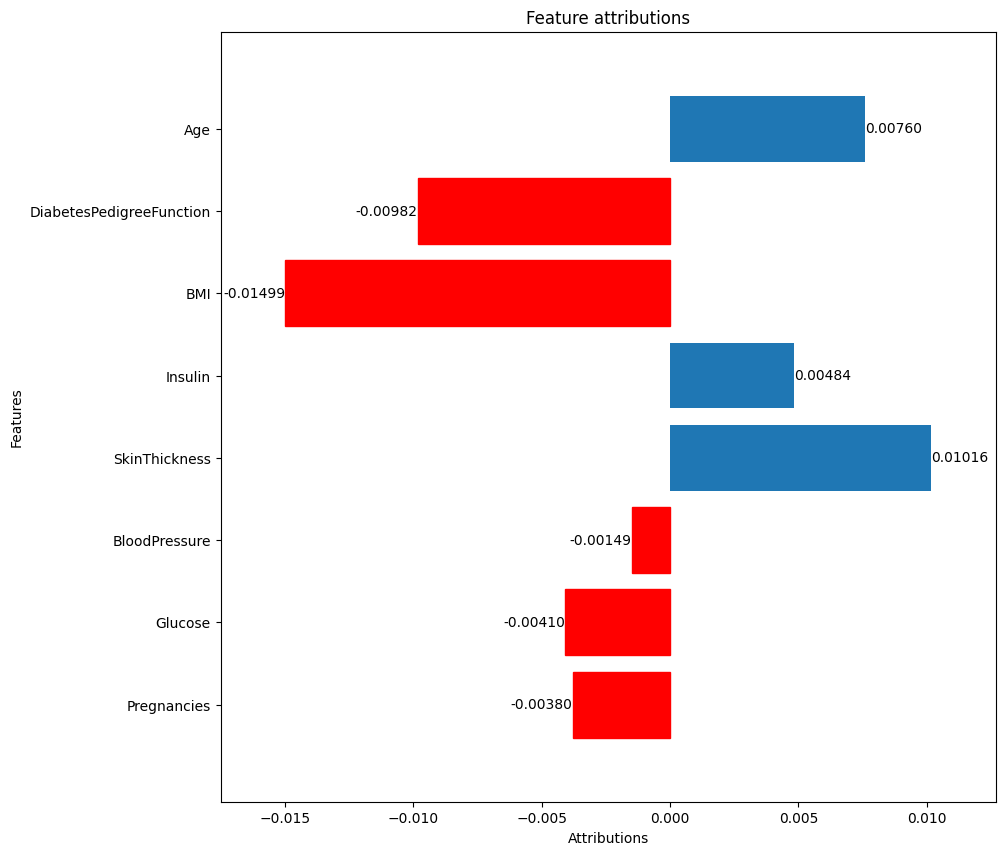

/usr/local/lib/python3.10/dist-packages/beexai/explanation/plot_attr.py:95: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/beexai/explanation/plot_attr.py:95: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/beexai/explanation/plot_attr.py:95: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

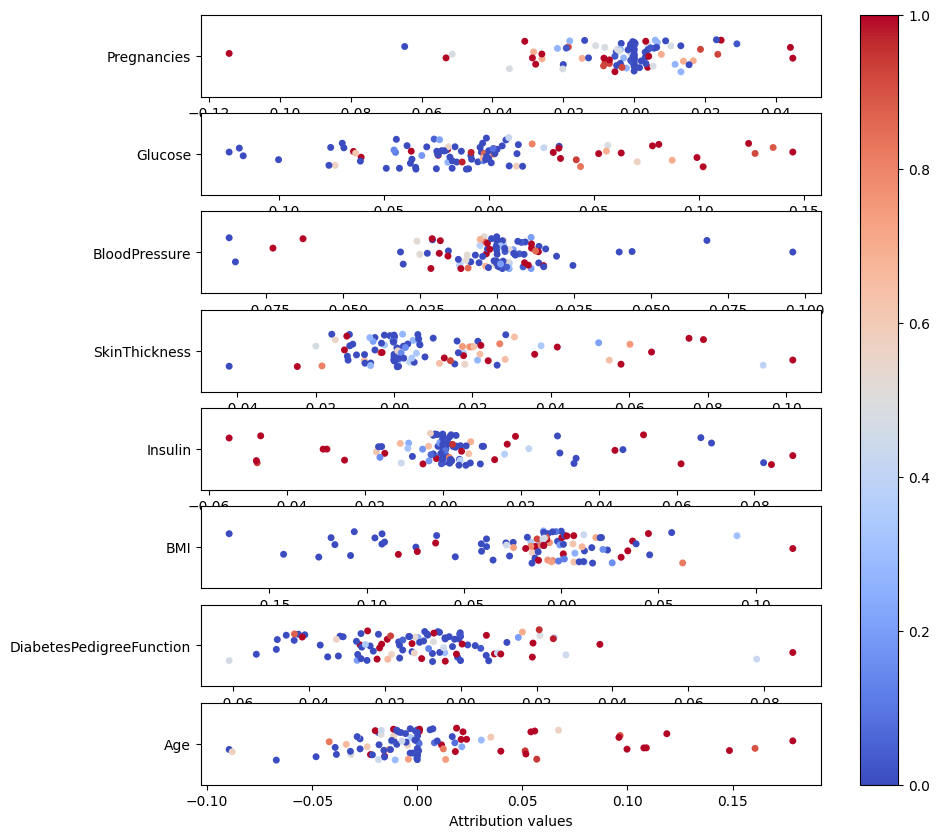

In [64]:
# Ensure attributions are correct
print("Attributions shape:", attributions.shape)
if len(attributions.shape) == 1:
    attributions = attributions.reshape(-1, len(features_names))

# Visualization: Bar plot, Waterfall plot, Swarm plot
bar_plot(attributions, feature_names=features_names, mean=True)

# Waterfall plot for a single sample
plot_waterfall(attributions[0], feature_names=features_names, mean=False)

# Swarm plot for the entire dataset
plot_swarm(X_test_sampled, attributions, feature_names=features_names)



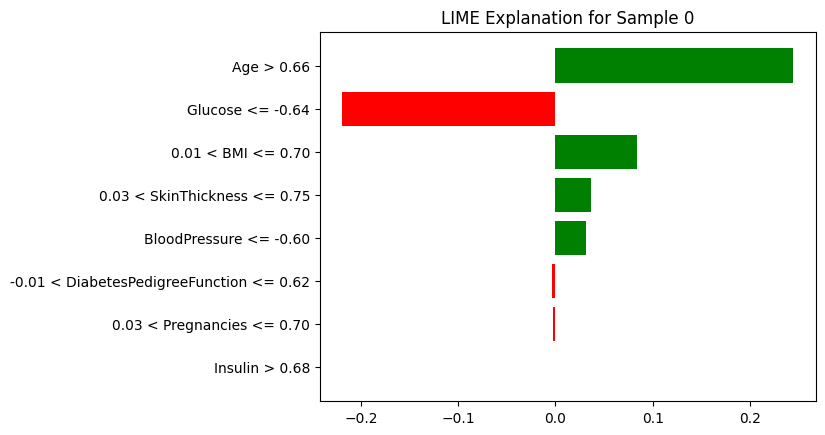

ExactExplainer explainer: 155it [00:11,  1.31it/s]


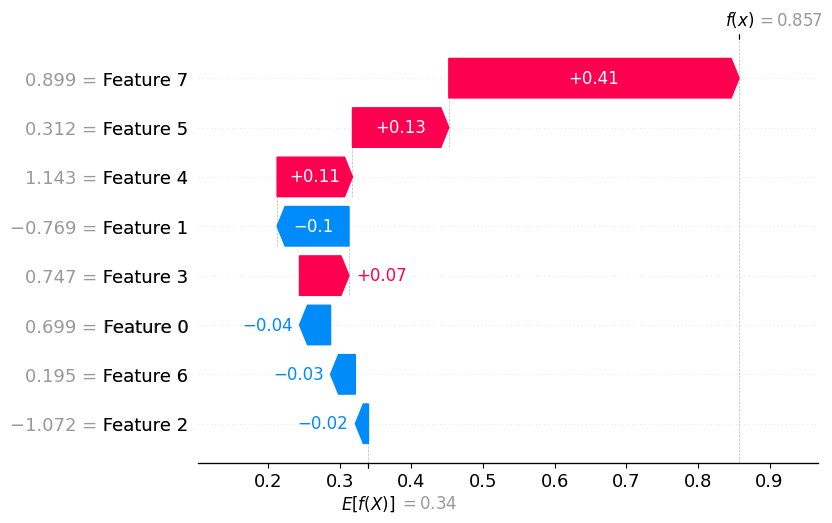

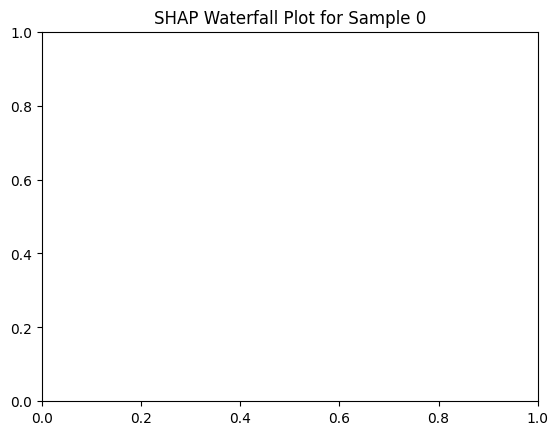

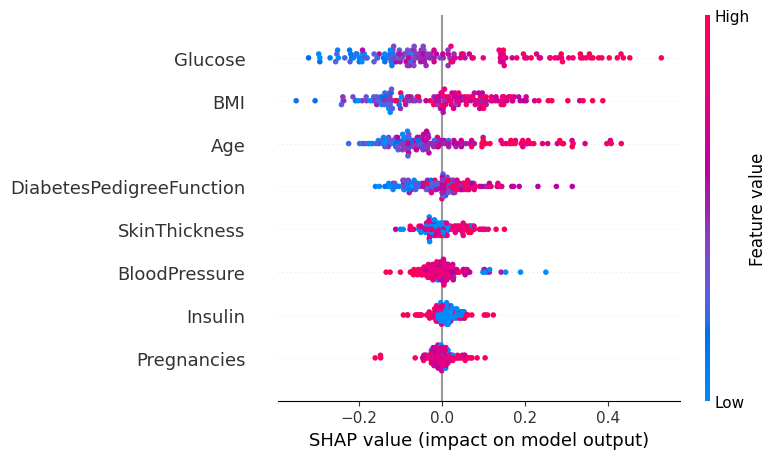

LIME and SHAP explanations saved to ./output/plots


In [65]:
!pip install Lime
import matplotlib.pyplot as plt
import shap
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

# Assuming X_test, y_test, and trainer.model are already defined
# Convert X_test to numpy for compatibility with LIME and SHAP
X_test_np = X_test.values

# Define a sample to explain
sample_index = 0  # Change this to visualize different samples
sample = X_test_np[sample_index].reshape(1, -1)
sample_prediction = trainer.model.predict(sample)

# Plot directory
plot_dir = "./output/plots"
os.makedirs(plot_dir, exist_ok=True)

# LIME Explanation
lime_explainer = LimeTabularExplainer(
    X_train.values,  # Training data for LIME
    feature_names=X_test.columns.tolist(),
    class_names=["Prediction"],  # For regression, class name can be generic
    mode="regression" if task == "regression" else "classification"
)
lime_exp = lime_explainer.explain_instance(sample.flatten(), trainer.model.predict, num_features=10)

# Plot LIME Explanation
lime_plot_path = os.path.join(plot_dir, f"LIME_Explanation_Sample{sample_index}.png")
lime_exp.as_pyplot_figure()
plt.title(f"LIME Explanation for Sample {sample_index}")
plt.savefig(lime_plot_path)
plt.show()

# SHAP Explanation
shap_explainer = shap.Explainer(trainer.model.predict, X_train.values)  # SHAP initialization
shap_values = shap_explainer(X_test_np)  # Compute SHAP values

# Plot SHAP Explanation for the sample
shap_plot_path = os.path.join(plot_dir, f"SHAP_Explanation_Sample{sample_index}.png")
shap.waterfall_plot(shap_values[sample_index], max_display=10)
plt.title(f"SHAP Waterfall Plot for Sample {sample_index}")
plt.savefig(shap_plot_path)
plt.show()

# Summary Plot for SHAP (Feature Importance for the Test Dataset)
summary_plot_path = os.path.join(plot_dir, "SHAP_Summary_Plot.png")
shap.summary_plot(shap_values, X_test_np, feature_names=X_test.columns, show=False)
plt.savefig(summary_plot_path)
plt.show()

print(f"LIME and SHAP explanations saved to {plot_dir}")